In [54]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [55]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/flower_photos")

In [56]:
batch_size = 32
img_height = 180
img_width = 180


Validation split 80% of the images for training, and 20% for validation.

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [60]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [61]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Dropout randomly drops out a number of output units from the layer during the training process. 

In [62]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

In [65]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 980s 2s/step - loss: 1.5120 - accuracy: 0.3405 - val_loss: 1.0804 - val_accuracy: 0.5531
Epoch 2/10
92/92 [==============================] - 2s 22ms/step - loss: 1.1088 - accuracy: 0.5538 - val_loss: 1.0347 - val_accuracy: 0.5804
Epoch 3/10
92/92 [==============================] - 2s 22ms/step - loss: 0.9717 - accuracy: 0.6140 - val_loss: 0.8781 - val_accuracy: 0.6431
Epoch 4/10
92/92 [==============================] - 2s 22ms/step - loss: 0.8844 - accuracy: 0.6569 - val_loss: 0.9140 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 2s 22ms/step - loss: 0.8255 - accuracy: 0.6703 - val_loss: 0.8910 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 2s 22ms/step - loss: 0.7492 - accuracy: 0.7176 - val_loss: 0.8211 - val_accuracy: 0.6744
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.7237 - accuracy: 0.7348 - val_loss: 0.7983 - val_accuracy: 0.6921
Epoch 8/10
92

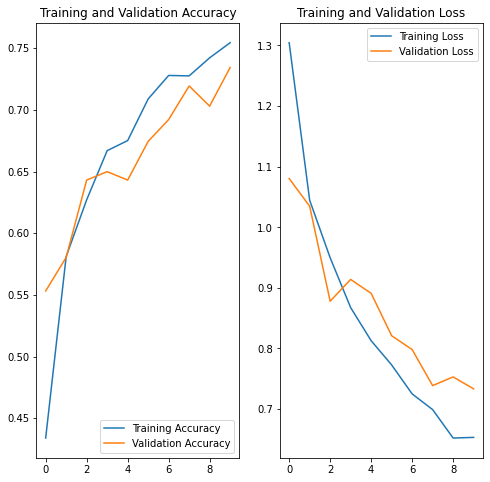

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/daisy.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to daisy with a 97.42 percent confidence.


In [68]:
model.save("my_h5_model.h5")